In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from sklearn.cross_decomposition import PLSRegression
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

"""
https://www.kaggle.com/competitions/titanic/data

Creating a model for predicting survival on the titanic

Created by Cin A. (aka Lance Aquino)
"""

df_gs = pd.read_csv("gender_submission.csv")
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")

# Preprocessing and exploratory analysis

In [2]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We should exclude the cabin category, due to the large number of NaNs.
Age should probably also be imputed by means, due to the high number of NaNs

We should also exclude names, as they won't be used in the model.

In [4]:
# converting label encoded data to their respective labels
survival_key = {0:"No", 1: "Yes"}
class_key = {1:"1st", 2 : "2", 3:"3rd"}


In [9]:
def process_data(df):
    """
    Removes columns that are redundant (Ticket) ,have many 
    NaNs (Cabin), or otherwise unimportant (Name) for applying a
    machine learning model from X, and separates the thing
    we're predicting (Survived) into y.
    
    returns:
    X: processed data where Ticket, Name, Cabin, and Survived are removed, PassengerId becomes the indeces
    y: processed data where survival status is recorded (0 for lived, 1 for not)
    """
        
    # sets PassengerId as the index for all data
    X = df.set_index("PassengerId")
    y = X["Survived"] # also set y to X["Survived"] before removing it
    
    # Removes unimportant columns and y data from the X df
    X = df.drop(["Survived","Ticket","Name","Cabin"],axis = 1)
    le = preprocessing.LabelEncoder()
    
    # encodes categorical data as ints
    X["Sex"] = le.fit_transform(X["Sex"])
    X["Embarked"] = le.fit_transform(X["Embarked"])
    
    # imputes NaN data in age by adding the mean of the column
    imp_means = SimpleImputer(missing_values=np.nan,strategy ="mean") #fills in NaNs
    age_arr = np.array(X["Age"]).reshape(-1,1) # need to reshape to get it to work in the imputer
    age_arr_imp = imp_means.fit_transform(age_arr) # fills in nans within X_processed 
    X["Age"] = age_arr_imp 
    
    return X,y
X,y = process_data(df_train)
X

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,1,22.000000,1,0,7.2500,2
1,2,1,0,38.000000,1,0,71.2833,0
2,3,3,0,26.000000,0,0,7.9250,2
3,4,1,0,35.000000,1,0,53.1000,2
4,5,3,1,35.000000,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,887,2,1,27.000000,0,0,13.0000,2
887,888,1,0,19.000000,0,0,30.0000,2
888,889,3,0,29.699118,1,2,23.4500,2
889,890,1,1,26.000000,0,0,30.0000,0


In [6]:
y

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [10]:
# converting label encoded data to their respective labels
survival_key = {0:"No", 1: "Yes"}
class_key = {1:"1st", 2 : "2", 3:"3rd"}

## Graph

#### Graphing data to see what's up

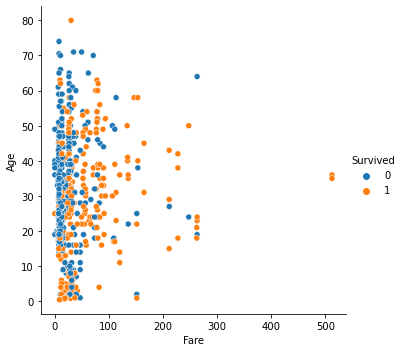

In [18]:
sns.relplot(
    x = "Fare",
    y= "Age",
    hue = "Survived",
    data = df_train
)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,1,22.000000,1,0,7.2500,2,No
1,2,1,0,38.000000,1,0,71.2833,0,Yes
2,3,3,0,26.000000,0,0,7.9250,2,Yes
3,4,1,0,35.000000,1,0,53.1000,2,Yes
4,5,3,1,35.000000,0,0,8.0500,2,No
...,...,...,...,...,...,...,...,...,...
886,887,2,1,27.000000,0,0,13.0000,2,No
887,888,1,0,19.000000,0,0,30.0000,2,Yes
888,889,3,0,29.699118,1,2,23.4500,2,No
889,890,1,1,26.000000,0,0,30.0000,0,Yes
